# Next Transaction Prediction: Binary Convolutional Example

The next set of examples are NTP or Next Transaction Prediction models. These models receive a series of transactions as input and will try to predict the next transaction.

These are a bit like auto-encoders in that they __do not need label__ data, the label is the next transaction. But rather than trying to predict the entire sequence, as we did with auto-encoders, we try to predict one transaction only, the last one to be exact. Because the last transaction (the label) is not part of the input data, we can do not need to be 'compressing' the data into a lower dimensional latent space.

Equal to the auto-encoders this may intially seem like a pretty pointless excersise. However as was the case with the auto-encoders we;
- Might have a similar intuition to auto-encoders. That when an NTP model makes a completely wrong prediction for what the next transaction will look like, that transaction might be a sort of anomaly.
- Predicting the Next Transaction will force our model to learn about transactions and distill those learning as 'latent features' in all sorts of layers. These latent feature might be useful when we start looking at __transfer learning__.


----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

# Imports

In [1]:
import torch
import numpy as np
import gc
import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object.

The series we build are 1 item longer than the ones in the encoder examples. The series will be a size of __6 transactions__. 5 transactions of which are the input data, 1 transaction, the last one, will be the label.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)


learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    trx_df = e.from_df(learning_features, df, inference=False)
    lb_df = e.from_df(label, df, inference=False)
    ser_np = e.to_series_stacked(
        trx_df, learning_features, key_field=customer, time_field=date_time, length=6
    )
    lb_np = e.to_numpy_list(label, lb_df)
    data_list = en.NumpyList(ser_np.lists + lb_np.lists)

learning_features.remove(customer)
learning_features.remove(date_time)
    
print('Data Shapes')
print(data_list.shapes)
print(data_list.dtype_names)

2021-02-27 15:11:09.208 d373c7.engines.common          INFO     Start Engine...
2021-02-27 15:11:09.208 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-02-27 15:11:09.209 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-02-27 15:11:09.209 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2021-02-27 15:11:09.420 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2021-02-27 15:11:09.433 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2021-02-27 15:11:09.434 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2021-02-27 15:11:09.452 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2021-02-27 15:11:09.453 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

Data Shapes
[(594643, 6, 107), (594643,)]
['int8', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

For NTP models we perform a 5th step, all fraud records will be removed from the training and validation data. The NTP model will only see *non-fraud* records during training.
> 1. Remove fraud records from training and validation


In [5]:
test_records = 100000
val_records  = 30000
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(model_features, 0)
val_data = val_data.filter_label(model_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del df, trx_df, lb_df, ser_np, lb_np, data_list
gc.collect()
print('Done')

Training Data shapes [(429311, 6, 107), (429311,)]
Validation Data shapes [(29670, 6, 107), (29670,)]
Test Data shapes [(100000, 6, 107), (100000,)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2021-02-27 15:11:20.117 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2021-02-27 15:11:20.152 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-02-27 15:11:20.152 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model

> In this example we use a `GeneratedNtp` model, the same model as we used in the 'single' encoder examples. But as we now have series, we can ask it to use the specialised +3-D tensor layers. We're asking it to use 2 convolutional layers. The first layer reduces to __16 features/channels with a kernel_size of 2__, the second layer applies __32 features/channels with a kernel_size of 1__. One further linear layer of size 32 is added between the convolutional layers and the final autoput layer.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

m = pm.GeneratedNtp(model_features, convolutional_layers=[(16, 2), (32, 1)], linear_layers=[64])

print(m)

GeneratedNtp(
  Number of parameters : 19259. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(lcs=['Binary'])
      (ntp_conv_body): ConvolutionalNtpBody(
        (conv_layers): Sequential(
          (conv_01): Conv1d(107, 16, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU()
          (conv_02): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
          (relu_02): ReLU()
          (norm_02): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=128, out_features=64, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.2, inplace=False)
      (tail_binary): Linear(in_features=64, out_features=107, bias=True)
      (tail_bin_act): Sigmoid()
    )
  )
)


2021-02-27 15:11:23.953 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 300.88it/s]
2021-02-27 15:11:25.884 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


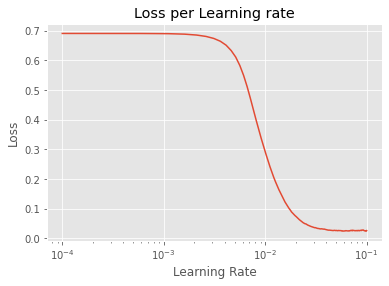

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __5 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 5 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 005/005: 100%|██████████| 3586/3586 [00:09<00:00, 363.15it/s, train_loss=0.0183, val_loss=0.0184]


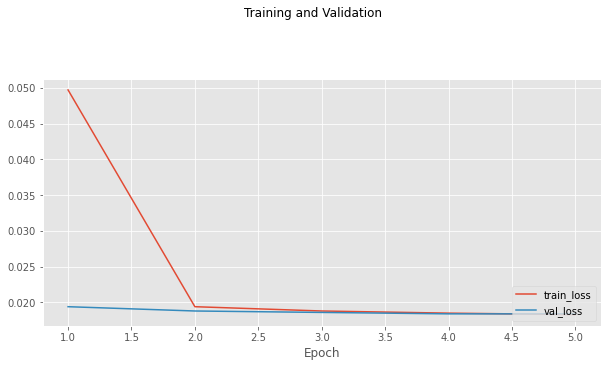

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Our first NTP seems to fare OK, much like in the auto-encoder examples we'd be tempted to think that there is some correlation between the reconstruction score and the fraud. So transactions that are more difficult to reconstruct are anomalous and in this case the anomaly quite often seems to be the fact the reconstructed transaction is fraudulent. 

> We observe that in the extremes, the score seems to correlate with our fraud label. Very low score are all non-frauds. The hight score are all non-frauds. But there is a middle area around one where the non-fraud count spikes up. 

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1109.61it/s]


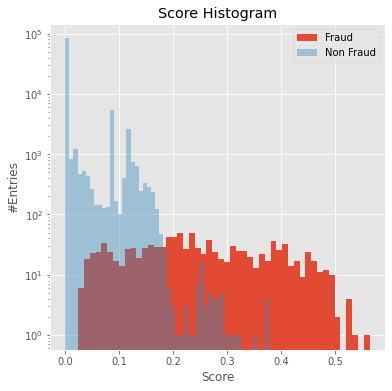

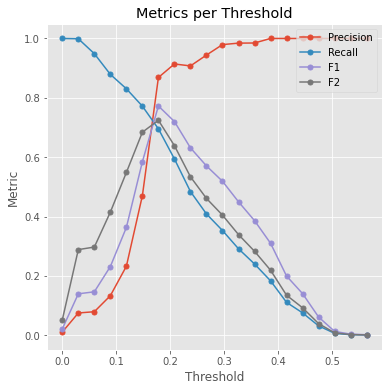

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.79      0.71      0.75      1074

    accuracy                           0.99    100000
   macro avg       0.90      0.85      0.87    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9817
ap score  : 0.7539
-----------------------------------------------------


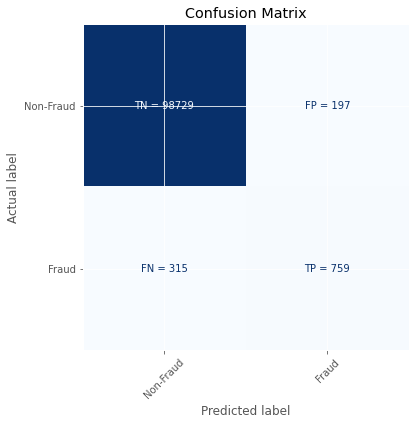

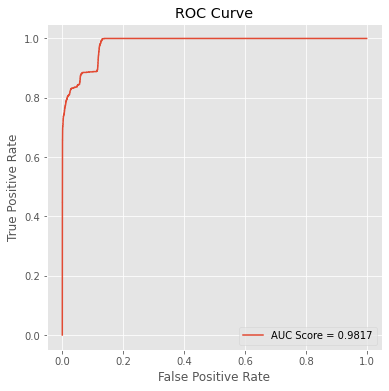

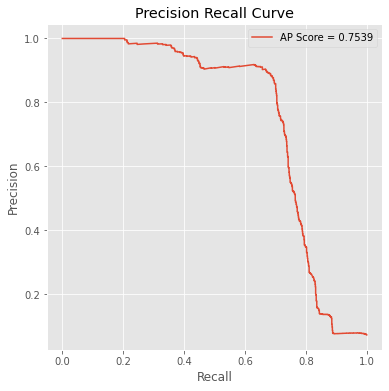

In [30]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=0.17)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=0.17)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

# Conclusion
With the by now standard caveats on the data, we are led to believe that the Next Transaction Prediction models might have similar behaviours as the encoders in that when they predict the next transaction completely wrong, the transaction is an anomaly.